In [1]:
import torch
torch.cuda.empty_cache()
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import os


ablation_study_id = 5
os.chdir('../')
print(os.getcwd())

/data/users/cs24s008/aacb_project/multi-modal-framework-for-cancer-cell-line-prediction


In [2]:
gdsc_df = pd.read_csv("dataset/GDSC_SMILES_merged.csv", index_col=0)
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O


In [3]:
ccl_rep_df = pd.read_csv("dataset/PANCANCER_Genetic_feature.csv")

# Pivot to get binary matrix: rows = cell lines, columns = features
binary_feature_matrix = ccl_rep_df.pivot_table(
    index="cell_line_name",
    columns="genetic_feature",
    values="is_mutated",
    fill_value=0
).astype(int)

In [4]:
binary_feature_matrix.columns = binary_feature_matrix.columns.astype(str)

In [5]:
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
201T,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22RV1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23132-87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42-MG-BA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451Lu,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZR-75-30,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
huH-1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [6]:
binary_feature_matrix.index = binary_feature_matrix.index.str.upper()

In [7]:
import re

def clean_name(name):
    return re.sub(r'[^A-Za-z0-9]', '', name).upper()

### CCL embeddings

In [8]:
binary_feature_matrix.index = binary_feature_matrix.index.to_series().apply(clean_name)
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
201T,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22RV1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42MGBA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451LU,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZR7530,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
HUH1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


### Drugs

In [9]:
gdsc_df["CLEAN_CELL_LINE"] = gdsc_df["CELL_LINE_NAME"].apply(clean_name)
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,CLEAN_CELL_LINE
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,PFSK1
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,A673
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,ES5
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,ES7
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,EW11
...,...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O,SNU175
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O,SNU407
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O,SNU61
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O,SNUC5


### Fingerprints

In [10]:
def compute_morgan(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [0] * n_bits
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return list(fp)


In [11]:
unique_drugs = gdsc_df[["DRUG_ID", "SMILES"]].drop_duplicates().reset_index(drop=True)
unique_drugs["FINGERPRINT"] = unique_drugs["SMILES"].apply(compute_morgan)
fingerprint_dict = dict(zip(unique_drugs["DRUG_ID"], unique_drugs["FINGERPRINT"]))

[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerator
[00:02:46] DEPRECATION WARNING: please use MorganGenerat

### GSVA scores

In [12]:
gsva_df = pd.read_csv("dataset/ccle_gsva_scores.csv", index_col=0)
gsva_df

,X22RV1_PROSTATE,X2313287_STOMACH,X253JBV_URINARY_TRACT,X253J_URINARY_TRACT,X42MGBA_CENTRAL_NERVOUS_SYSTEM,X5637_URINARY_TRACT,X59M_OVARY,X639V_URINARY_TRACT,X647V_URINARY_TRACT,X697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,0.244789,-0.083931,0.279529,0.208577,-0.132328,0.215197,0.319143,-0.075647,0.277187,0.271370,...,0.075112,0.327630,-0.375213,-0.355703,-0.101719,-0.530021,-0.537348,0.275503,0.526732,0.220102
KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,0.232631,0.414819,0.290806,0.670978,-0.274907,0.192912,0.640286,-0.506128,-0.057853,-0.455609,...,-0.274736,0.131784,0.551961,0.211546,-0.032558,0.151900,0.317689,-0.332108,-0.430653,0.182114
KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,-0.186705,0.177009,-0.414291,-0.038181,0.207581,0.134153,0.586046,-0.158105,-0.045624,-0.519046,...,-0.145654,0.178017,0.254041,-0.116195,-0.179142,0.231483,0.155220,0.205721,-0.166378,0.045039
KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,-0.540508,-0.258760,-0.138647,0.146632,-0.384697,-0.019662,0.407990,-0.288576,-0.125966,0.616469,...,0.087120,-0.160979,0.192224,0.457628,0.006197,-0.417248,-0.453304,-0.136213,0.387118,0.503203
KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,-0.166025,0.121127,-0.259766,-0.369504,0.117981,0.406653,-0.132804,0.414331,0.543123,-0.071814,...,0.112035,0.091719,-0.332850,0.156438,-0.064297,0.338911,0.224560,0.143953,0.002501,0.102778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,-0.117058,0.534826,0.499067,0.476963,0.491432,-0.041223,-0.021224,-0.637564,-0.262915,-0.128982,...,-0.316305,-0.194693,0.727817,0.157373,0.250761,-0.209867,0.035322,0.055748,0.194295,0.100961
KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,-0.071946,-0.235064,-0.158232,-0.471312,0.069451,0.552709,-0.219726,-0.231657,0.247514,0.479034,...,0.471183,0.543891,0.173360,0.325866,0.628831,0.454693,0.169221,0.040660,-0.249230,-0.453372
KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,-0.288375,-0.230789,-0.043607,-0.100954,-0.003728,0.443881,-0.040789,-0.123535,0.551131,0.003992,...,-0.070541,0.065449,0.058856,0.208207,0.303945,0.378906,0.233616,0.152003,-0.139507,-0.157565
KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,-0.566128,-0.454890,0.398130,0.312828,0.524678,0.477288,0.634019,-0.273644,0.437712,0.101343,...,0.100011,-0.227126,0.728999,0.366406,0.542634,-0.223423,0.224992,0.234498,-0.452274,-0.463809


In [13]:
gdsc_df["CELL_LINE_NAME"] = gdsc_df["CELL_LINE_NAME"].str.strip().str.upper()
cell_lines_obs = set(gdsc_df["CELL_LINE_NAME"].unique())

gsva_df.columns = gsva_df.columns.str.strip().str.upper()
cell_lines_available = sorted(set(gsva_df.columns.str.split("_").str[0].str.upper()))

In [14]:
cell_lines_available = {clean_name(name) for name in cell_lines_available}
cell_lines_obs = {clean_name(name) for name in cell_lines_obs}

In [15]:
common_cell_lines = cell_lines_obs.intersection(cell_lines_available)
print("Now common cell lines:", len(common_cell_lines))

Now common cell lines: 607


In [16]:
gsva_df.columns = gsva_df.columns.str.split("_").str[0].str.upper().to_series().apply(clean_name)
gsva_df.columns.has_duplicates

True

In [17]:
gsva_df = gsva_df.loc[:, ~gsva_df.columns.duplicated()]
print(gsva_df.columns.has_duplicates)
gsva_df

False


,X22RV1,X2313287,X253JBV,X253J,X42MGBA,X5637,X59M,X639V,X647V,X697,...,WSUDLCL2,YAPC,YD10B,YD15,YD38,YD8,YH13,YKG1,ZR751,ZR7530
KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,0.244789,-0.083931,0.279529,0.208577,-0.132328,0.215197,0.319143,-0.075647,0.277187,0.271370,...,0.075112,0.327630,-0.375213,-0.355703,-0.101719,-0.530021,-0.537348,0.275503,0.526732,0.220102
KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,0.232631,0.414819,0.290806,0.670978,-0.274907,0.192912,0.640286,-0.506128,-0.057853,-0.455609,...,-0.274736,0.131784,0.551961,0.211546,-0.032558,0.151900,0.317689,-0.332108,-0.430653,0.182114
KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,-0.186705,0.177009,-0.414291,-0.038181,0.207581,0.134153,0.586046,-0.158105,-0.045624,-0.519046,...,-0.145654,0.178017,0.254041,-0.116195,-0.179142,0.231483,0.155220,0.205721,-0.166378,0.045039
KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,-0.540508,-0.258760,-0.138647,0.146632,-0.384697,-0.019662,0.407990,-0.288576,-0.125966,0.616469,...,0.087120,-0.160979,0.192224,0.457628,0.006197,-0.417248,-0.453304,-0.136213,0.387118,0.503203
KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,-0.166025,0.121127,-0.259766,-0.369504,0.117981,0.406653,-0.132804,0.414331,0.543123,-0.071814,...,0.112035,0.091719,-0.332850,0.156438,-0.064297,0.338911,0.224560,0.143953,0.002501,0.102778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,-0.117058,0.534826,0.499067,0.476963,0.491432,-0.041223,-0.021224,-0.637564,-0.262915,-0.128982,...,-0.316305,-0.194693,0.727817,0.157373,0.250761,-0.209867,0.035322,0.055748,0.194295,0.100961
KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,-0.071946,-0.235064,-0.158232,-0.471312,0.069451,0.552709,-0.219726,-0.231657,0.247514,0.479034,...,0.471183,0.543891,0.173360,0.325866,0.628831,0.454693,0.169221,0.040660,-0.249230,-0.453372
KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,-0.288375,-0.230789,-0.043607,-0.100954,-0.003728,0.443881,-0.040789,-0.123535,0.551131,0.003992,...,-0.070541,0.065449,0.058856,0.208207,0.303945,0.378906,0.233616,0.152003,-0.139507,-0.157565
KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,-0.566128,-0.454890,0.398130,0.312828,0.524678,0.477288,0.634019,-0.273644,0.437712,0.101343,...,0.100011,-0.227126,0.728999,0.366406,0.542634,-0.223423,0.224992,0.234498,-0.452274,-0.463809


# Creating Dataset

In [18]:
from rdkit import Chem
import torch
from torch_geometric.data import Data

from torch.utils.data import Dataset


In [19]:
# Define categorical vocabularies
ATOM_LIST = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'H', 'B', 'Si', 'Na', 'K', 'Li', 'Mg', 'Ca', 'Fe', 'Zn', 'Se', 'Cu']
DEGREE_LIST = list(range(0, 11))
VALENCE_LIST = list(range(0, 7))
HYBRIDIZATION_LIST = [
    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
TOTAL_H_LIST = [0, 1, 2, 3, 4]
CHIRALITY_LIST = ['R', 'S']

In [20]:
def one_hot_encoding(x, allowable):
    return [int(x == s) for s in allowable]

In [21]:
def atom_features(atom):
    features = []
    features += one_hot_encoding(atom.GetSymbol(), ATOM_LIST)
    features += one_hot_encoding(atom.GetDegree(), DEGREE_LIST)
    features += one_hot_encoding(atom.GetImplicitValence(), VALENCE_LIST)
    features.append(atom.GetFormalCharge())
    features.append(atom.GetNumRadicalElectrons())
    features += one_hot_encoding(atom.GetHybridization(), HYBRIDIZATION_LIST)
    features.append(int(atom.GetIsAromatic()))
    features += one_hot_encoding(atom.GetTotalNumHs(), TOTAL_H_LIST)
    features.append(int(atom.IsInRing()))
    
    chirality = atom.GetProp('_CIPCode') if atom.HasProp('_CIPCode') else None
    features += one_hot_encoding(chirality, CHIRALITY_LIST)
    
    return features


In [22]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    atom_feats = [atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_feats, dtype=torch.float)

    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # undirected

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    return Data(x=x, edge_index=edge_index)

In [23]:
import re
from torch.utils.data import Dataset
import torch

class ModifiedMGATAFDataset(Dataset):
    def __init__(self, gdsc_df, fingerprint_dict, cell_feature_matrix, gsva_matrix, graph_dict):
        self.df = gdsc_df
        self.fingerprint_dict = fingerprint_dict  # drug_id -> np.array or list
        self.cell_features = cell_feature_matrix  # DataFrame: index=cell_line_name, values=mutation+cnv
        self.gsva_matrix = gsva_matrix            # DataFrame: index=cell_line_name, values=gsva scores
        self.graphs = graph_dict                  # drug_id -> graph object (PyG or DGL)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug_id = row["DRUG_ID"]
        cell_line = row["CLEAN_CELL_LINE"]

        # Drug molecular graph
        graph_data = self.graphs[drug_id]

        # Fingerprint vector
        fingerprint = torch.tensor(self.fingerprint_dict[drug_id], dtype=torch.float)

        # Cell line mutation/CNV features
        ccl_feat = torch.tensor(self.cell_features.loc[cell_line].values, dtype=torch.float)

        # GSVA pathway scores
        if cell_line not in gsva_matrix.index:
            raise ValueError(f"{cell_line} not found in GSVA matrix.")
        gsva_feat = torch.tensor(self.gsva_matrix.loc[cell_line].values, dtype=torch.float)

        # Target IC50
        ic50 = torch.tensor([row["LN_IC50"]], dtype=torch.float)

        return graph_data, fingerprint, ccl_feat, gsva_feat, ic50


In [24]:
# Step 1: Clean the GDSC cell line column
# gdsc_df["CELL_LINE_NAME_CLEAN"] = gdsc_df["CELL_LINE_NAME"].apply(clean_name)

# Step 2: Clean the index of the binary feature matrix
binary_feature_matrix.index = binary_feature_matrix.index.to_series().apply(clean_name)
binary_feature_matrix = binary_feature_matrix[~binary_feature_matrix.index.duplicated(keep='first')]

# Step 3: Clean GSVA matrix columns
gsva_df.columns = gsva_df.columns.to_series().apply(clean_name)
gsva_df = gsva_df.loc[:, ~gsva_df.columns.duplicated(keep='first')]

# Step 4: Determine valid IDs
valid_drugs = set(fingerprint_dict.keys())
valid_mutcnv_cells = set(binary_feature_matrix.index)
valid_gsva_cells = set(gsva_df.columns)

# Step 5: Get cell lines common to all three
common_cell_lines = valid_mutcnv_cells & valid_gsva_cells & set(gdsc_df["CLEAN_CELL_LINE"])
common_cell_lines = list(common_cell_lines)
# Step 6: Filter gdsc_df to keep only rows with common cell lines and valid drugs/SMILES
gdsc_df = gdsc_df[
    gdsc_df["DRUG_ID"].isin(valid_drugs) &
    gdsc_df["CLEAN_CELL_LINE"].isin(common_cell_lines) &
    gdsc_df["SMILES"].notna()
].reset_index(drop=True)

# Step 7: Filter binary_feature_matrix and gsva_matrix to keep only common cell lines
binary_feature_matrix = binary_feature_matrix.loc[common_cell_lines]
gsva_df = gsva_df.loc[:, list(common_cell_lines)]  # since cell lines are columns

# Normalise the ln IC50 values
gdsc_df['LN_IC50'] = 1 / (np.exp(-0.1 * gdsc_df['LN_IC50']) + 1)

In [25]:
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,CLEAN_CELL_LINE
0,1003,Camptothecin,A673,0.380614,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,A673
1,1003,Camptothecin,SK-ES-1,0.374186,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,SKES1
2,1003,Camptothecin,COLO-829,0.469282,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,COLO829
3,1003,Camptothecin,RT4,0.426465,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,RT4
4,1003,Camptothecin,SW780,0.463887,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,SW780
...,...,...,...,...,...,...
125091,2499,N-acetyl cysteine,MM1S,0.717484,CC(=O)NC(CS)C(=O)O,MM1S
125092,2499,N-acetyl cysteine,SNU-175,0.733695,CC(=O)NC(CS)C(=O)O,SNU175
125093,2499,N-acetyl cysteine,SNU-407,0.702150,CC(=O)NC(CS)C(=O)O,SNU407
125094,2499,N-acetyl cysteine,SNU-61,0.741172,CC(=O)NC(CS)C(=O)O,SNU61


In [26]:
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
JHOS4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,0,0
LOVO,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SNB75,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
MFE296,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COLO680N,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SW1417,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,0
KNS62,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
TOV112D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
drug_smiles = gdsc_df.drop_duplicates(subset="DRUG_ID")[["DRUG_ID", "SMILES"]]

In [28]:
precomputed_graphs = {}
for _, row in drug_smiles.iterrows():
    drug_id = row["DRUG_ID"]
    smi = row["SMILES"]
    graph = smiles_to_graph(smi)
    if graph is not None:
        precomputed_graphs[drug_id] = graph

In [29]:
gsva_df

,JHOS4,LOVO,SNB75,MFE296,COLO680N,NCIH3122,NCIN87,UMUC3,A673,NCIH226,...,NCIH2023,P12ICHIKAWA,CW2,TE11,HSC2,SW1417,KNS62,TOV112D,HS683,NCIH2291
KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,0.432590,0.555704,-0.485945,-0.201341,-0.184066,0.091954,0.417959,0.214643,0.018496,0.341870,...,0.362941,0.335976,0.414138,0.111513,-0.506730,-0.093064,-0.504850,0.100726,-0.565114,-0.186924
KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,0.083351,0.510153,0.162814,-0.060181,0.397238,0.679646,0.500252,-0.534608,-0.009474,-0.436246,...,0.701405,-0.464542,0.167414,0.704062,0.706788,-0.204193,0.663649,-0.227998,0.178076,0.080557
KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,0.419475,0.387542,0.176496,0.332853,-0.082617,-0.062948,0.278816,-0.234376,0.253067,-0.537549,...,0.230424,-0.584411,0.130155,0.619270,0.255562,-0.024374,0.510961,0.096490,0.326659,-0.051790
KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,0.069176,0.255471,-0.387905,-0.327231,0.451391,0.520426,-0.471404,-0.126740,0.034885,-0.155703,...,0.262966,-0.364355,0.361477,0.612461,0.530768,0.046431,0.660897,0.010933,-0.354431,0.316342
KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,0.385006,-0.236479,0.573474,0.179356,-0.313710,-0.379883,-0.452793,-0.057332,0.044851,0.179046,...,-0.338295,-0.082807,0.012960,0.189287,-0.094524,-0.262920,-0.318551,-0.276267,0.186349,0.043274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,-0.380983,-0.232831,0.505364,-0.187279,-0.082843,0.073855,0.210508,-0.052309,-0.202008,0.171241,...,-0.031945,-0.378036,-0.156324,0.164448,0.718223,0.354112,0.613615,0.388472,0.032610,-0.127789
KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,-0.273720,-0.083250,-0.013848,-0.027251,-0.339698,0.429224,0.049538,0.312755,-0.043965,-0.093726,...,-0.523414,0.685297,0.382527,0.062603,-0.105280,0.159257,-0.045637,-0.053436,0.073938,0.170981
KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,0.131527,-0.422259,0.352528,-0.361815,0.437703,-0.552732,-0.220070,0.182350,-0.523954,0.166346,...,-0.385182,-0.122964,-0.632942,0.200669,0.294199,-0.174414,0.175520,-0.509112,0.403101,0.216514
KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,-0.024056,0.296612,0.283158,-0.358232,-0.084754,0.284692,-0.297701,0.533641,-0.240124,0.125730,...,-0.105339,-0.187438,0.048553,0.511780,0.596917,0.013372,0.528641,-0.560731,0.364643,0.434116


In [30]:
gsva_matrix = gsva_df.T  # Now cell lines are rows
gsva_matrix

,KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_IRON_TO_ANTEROGRADE_AXONAL_TRANSPORT,KEGG_MEDICUS_ENV_FACTOR_METALS_TO_JNK_SIGNALING_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_METALS_TO_KEAP1_NRF2_SIGNALIG_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_METALS_TO_NFKB_SIGNALING_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_METALS_TO_RAS_ERK_SIGNALING_PATHWAY,...,KEGG_MEDICUS_VARIANT_RET_FUSION_KINASE_TO_RAS_ERK_SIGNALING_PATHWAY,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_26S_PROTEASOME_MEDIATED_PROTEIN_DEGRADATION,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_MGLUR5_CA2_APOPTOTIC_PATHWAY,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_PERK_ATF4_SIGNALING_PATHWAY,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_TRANSPORT_OF_CALCIUM,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,KEGG_MEDICUS_VARIANT_TRK_FUSION_KINASE_TO_RAS_ERK_SIGNALING_PATHWAY
JHOS4,0.432590,0.083351,0.419475,0.069176,0.385006,-0.198539,-0.079495,-0.422831,0.277818,0.325294,...,0.292105,-0.110997,0.156009,0.047042,0.204756,-0.380983,-0.273720,0.131527,-0.024056,0.179111
LOVO,0.555704,0.510153,0.387542,0.255471,-0.236479,-0.220190,0.474187,0.093949,-0.381498,-0.300684,...,-0.302409,-0.660143,-0.022464,-0.752137,0.290863,-0.232831,-0.083250,-0.422259,0.296612,-0.332240
SNB75,-0.485945,0.162814,0.176496,-0.387905,0.573474,0.539820,0.104697,0.282656,0.419424,0.571917,...,0.643490,0.017535,-0.023009,0.366895,-0.171446,0.505364,-0.013848,0.352528,0.283158,0.564786
MFE296,-0.201341,-0.060181,0.332853,-0.327231,0.179356,0.283978,-0.383020,-0.013243,-0.039397,0.248642,...,0.473308,0.421142,0.105209,-0.681868,0.113971,-0.187279,-0.027251,-0.361815,-0.358232,0.236177
COLO680N,-0.184066,0.397238,-0.082617,0.451391,-0.313710,-0.584572,-0.118906,-0.363114,-0.085742,-0.436941,...,-0.416373,-0.316791,-0.395260,0.627834,-0.514466,-0.082843,-0.339698,0.437703,-0.084754,-0.453171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SW1417,-0.093064,-0.204193,-0.024374,0.046431,-0.262920,0.035714,-0.225832,-0.329224,-0.050636,-0.321349,...,-0.325898,0.079504,-0.452206,-0.501379,-0.394948,0.354112,0.159257,-0.174414,0.013372,-0.327057
KNS62,-0.504850,0.663649,0.510961,0.660897,-0.318551,-0.203100,-0.015185,0.236812,-0.454245,-0.442581,...,-0.397049,-0.443958,0.243689,0.610065,0.062191,0.613615,-0.045637,0.175520,0.528641,-0.401474
TOV112D,0.100726,-0.227998,0.096490,0.010933,-0.276267,0.225899,-0.548736,-0.512618,-0.123677,-0.305513,...,-0.203873,0.021446,-0.135143,-0.389209,0.065397,0.388472,-0.053436,-0.509112,-0.560731,-0.196404
HS683,-0.565114,0.178076,0.326659,-0.354431,0.186349,0.460155,0.419542,0.291256,0.013869,0.248696,...,0.013268,0.436708,-0.303095,-0.184126,-0.466410,0.032610,0.073938,0.403101,0.364643,-0.059299


In [31]:
print(f"Total {len(common_cell_lines)} common cell lines")
common_cell_lines = np.array(common_cell_lines)
np.random.shuffle(common_cell_lines)
cell_lines_train = common_cell_lines[: int(0.8*common_cell_lines.shape[0])]
cell_lines_test = common_cell_lines[int(0.8*common_cell_lines.shape[0]) : int(0.9*common_cell_lines.shape[0])]
cell_lines_val = common_cell_lines[int(0.9*common_cell_lines.shape[0]):]
print(f"Train: {cell_lines_train.shape[0]} cell lines")
print(f"Test: {cell_lines_test.shape[0]} cell lines")
print(f"Val: {cell_lines_val.shape[0]} cell lines")

train_set = ModifiedMGATAFDataset(
    gdsc_df=gdsc_df[gdsc_df["CLEAN_CELL_LINE"].isin(cell_lines_train)].reset_index(drop=True),
    fingerprint_dict=fingerprint_dict,
    cell_feature_matrix=binary_feature_matrix,
    gsva_matrix=gsva_matrix,
    graph_dict=precomputed_graphs
)
val_set = ModifiedMGATAFDataset(
    gdsc_df=gdsc_df[gdsc_df["CLEAN_CELL_LINE"].isin(cell_lines_val)].reset_index(drop=True),
    fingerprint_dict=fingerprint_dict,
    cell_feature_matrix=binary_feature_matrix,
    gsva_matrix=gsva_matrix,
    graph_dict=precomputed_graphs
)
test_set = ModifiedMGATAFDataset(
    gdsc_df=gdsc_df[gdsc_df["CLEAN_CELL_LINE"].isin(cell_lines_test)].reset_index(drop=True),
    fingerprint_dict=fingerprint_dict,
    cell_feature_matrix=binary_feature_matrix,
    gsva_matrix=gsva_matrix,
    graph_dict=precomputed_graphs
)

print(f"Train: {len(train_set)} pairs")
print(f"Val: {len(val_set)} pairs")
print(f"Val: {len(test_set)} pairs")

Total 601 common cell lines
Train: 480 cell lines
Test: 60 cell lines
Val: 61 cell lines
Train: 100522 pairs
Val: 12470 pairs
Val: 12104 pairs


In [32]:
sample = train_set[0]
graph, fingerprint, cell_feat, gsva_feat, label = sample

print("Graph:")
print(graph)
print("Graph node features shape:", graph.x.shape)
print("Graph edge_index shape:", graph.edge_index.shape)
print()

print("Fingerprint shape:", fingerprint.shape)
print("Cell line features shape:", cell_feat.shape)
print("GSVA features shape:", gsva_feat.shape)
print("Label (ln_IC50):", label)


Graph:
Data(x=[26, 55], edge_index=[2, 60])
Graph node features shape: torch.Size([26, 55])
Graph edge_index shape: torch.Size([2, 60])

Fingerprint shape: torch.Size([2048])
Cell line features shape: torch.Size([735])
GSVA features shape: torch.Size([658])
Label (ln_IC50): tensor([0.3806])


In [33]:
from torch_geometric.data import Batch

def modified_mgataf_collate_fn(batch):
    graphs, fingerprints, ccl_feats, gsva_feats, labels = zip(*batch)

    # Batch graph objects using PyG
    graph_batch = Batch.from_data_list(graphs)

    # Stack other tensors
    fingerprint_batch = torch.stack(fingerprints)
    ccl_feat_batch = torch.stack(ccl_feats)
    gsva_feat_batch = torch.stack(gsva_feats)
    label_batch = torch.stack(labels)

    return graph_batch, fingerprint_batch, ccl_feat_batch, gsva_feat_batch, label_batch


# Model Build

## Encoding

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_add_pool

In [35]:
class DrugGraphEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_dim=128, num_layers=3, heads=4):
        super().__init__()
        self.gats = nn.ModuleList()
        self.num_layers = num_layers
        self.att_proj = nn.Linear(hidden_dim, 1)

        self.gats.append(GATConv(in_dim, hidden_dim, heads=heads, concat=False))
        for _ in range(1, num_layers):
            self.gats.append(GATConv(hidden_dim, hidden_dim, heads=heads, concat=False))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        layer_outputs = []

        for gat in self.gats:
            x = F.relu(gat(x, edge_index))
            pooled = global_add_pool(x, batch)
            layer_outputs.append(pooled)

        h = torch.stack(layer_outputs, dim=1)  # [B, L, D]
        attn_weights = F.softmax(self.att_proj(h).squeeze(-1), dim=1)  # [B, L]
        h_weighted = (h * attn_weights.unsqueeze(-1)).sum(dim=1)  # [B, D]
        return h_weighted

In [36]:
class FingerprintEncoder(nn.Module):
    def __init__(self, in_dim=2048, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        # Dummy pass to infer output size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_dim)
            conv_out = self.conv(dummy)
            conv_flat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_flat_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.fc(x)
        return x


In [37]:
class CellLineEncoder(nn.Module):
    def __init__(self, in_dim=735, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        # Dynamically infer flattened dimension
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_dim)
            conv_out = self.conv(dummy)
            flat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, 735]
        x = self.conv(x)
        x = self.fc(x)
        return x


In [38]:
class GSVAEncoder(nn.Module):
    def __init__(self, in_dim=658, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_dim)
            conv_out = self.conv(dummy)
            flat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, 658]
        x = self.conv(x)
        x = self.fc(x)
        return x


## Adaptive Fusion

In [39]:
class AdaptiveFusion(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gate_layer = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        # x1: drug + fp, x2: ccl
        concat = torch.cat([x1, x2], dim=1)
        gate = self.gate_layer(concat)

        fused = gate * x1 + (1 - gate) * x2
        return fused


## Final Dense Layer

In [40]:
class IC50Predictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)


## Complete Model

In [41]:
class ModifiedMGATAFModel(nn.Module):
    def __init__(self, atom_feat_dim=55, fingerprint_dim=2048, ccl_dim=735, gsva_dim=658, hidden_dim=128):
        super().__init__()
        self.drug_encoder = DrugGraphEncoder(in_dim=atom_feat_dim, hidden_dim=hidden_dim)
        # self.fp_encoder = FingerprintEncoder(in_dim=fingerprint_dim, out_dim=hidden_dim)

        # self.ccl_encoder = CellLineEncoder(in_dim=ccl_dim, out_dim=hidden_dim)
        self.gsva_encoder = GSVAEncoder(in_dim=gsva_dim, out_dim=hidden_dim)
        
        # self.drug_fusion = AdaptiveFusion(input_dim=hidden_dim, hidden_dim=hidden_dim)
        # self.cellline_fusion = AdaptiveFusion(input_dim=hidden_dim, hidden_dim=hidden_dim)  # new!
        self.fusion = AdaptiveFusion(input_dim=hidden_dim, hidden_dim=hidden_dim)

        self.regressor = IC50Predictor(input_dim=hidden_dim)

    def forward(self, graph_data, fingerprint, ccl_feat, gsva_feat):
        # Drug branch
        drug_repr = self.drug_encoder(graph_data)
        # fp_repr = self.fp_encoder(fingerprint)
        # drug_combined = drug_repr + fp_repr
        # drug_combined = self.drug_fusion(drug_repr, fp_repr)

        # Cell line branch
        # ccl_repr = self.ccl_encoder(ccl_feat)
        gsva_repr = self.gsva_encoder(gsva_feat)
        # final_ccl_repr = self.cellline_fusion(ccl_repr, gsva_repr)

        # Final fusion
        fused = self.fusion(drug_repr, gsva_repr)

        return self.regressor(fused)


# Training

### Creating DataLoaders

In [42]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=modified_mgataf_collate_fn)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=modified_mgataf_collate_fn)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=modified_mgataf_collate_fn)

### Training Loop

In [43]:
torch.backends.cudnn.benchmark = True

In [44]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
Device name: NVIDIA RTX 6000 Ada Generation


In [45]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

import os

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedMGATAFModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')
patience_counter = 0
max_patience = 10
num_epochs = 100


# Trackers
train_rmse_list = []
val_rmse_list = []
val_pcc_list = []


# Paths
checkpoint_model_path = f"models/checkpoints/modified_mgataf_ablation/modified_mgataf_checkpoint_model_{ablation_study_id}.pt"
checkpoint_opt_path = f"models/checkpoints/modified_mgataf_ablation/mgataf_checkpoint_optim_{ablation_study_id}.pt"
checkpoint_meta_path = f"models/checkpoints/modified_mgataf_ablation/mgataf_checkpoint_meta_{ablation_study_id}.pt"

# Defaults
start_epoch = 0

# Resume
if os.path.exists(checkpoint_model_path) and os.path.exists(checkpoint_opt_path) and os.path.exists(checkpoint_meta_path):
    print("🔄 Resuming model...")
    model.load_state_dict(torch.load(checkpoint_model_path))

    # if os.path.exists(checkpoint_opt_path):
    optimizer.load_state_dict(torch.load(checkpoint_opt_path))

    # if os.path.exists(checkpoint_meta_path):
    meta = torch.load(checkpoint_meta_path)
    start_epoch = meta["epoch"] + 1
    best_val_loss = meta["best_val_loss"]
    patience_counter = meta["patience_counter"]

    print(f"✅ Resumed from epoch {start_epoch} | Best Val Loss: {best_val_loss:.4f}")


for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    train_preds, train_labels = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    for batch_idx, (graph_data, fingerprint, ccl_feat, gsva_feat, label) in enumerate(loop):
        graph_data = graph_data.to(device)
        fingerprint = fingerprint.to(device)
        ccl_feat = ccl_feat.to(device)
        gsva_feat = gsva_feat.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(graph_data, fingerprint, ccl_feat, gsva_feat)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        train_preds.append(output.detach().cpu().numpy())
        train_labels.append(label.cpu().numpy())
        
        # Every N batches, compute and show running metrics
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
            pred_flat = np.concatenate(train_preds).flatten()
            label_flat = np.concatenate(train_labels).flatten()
            rmse = root_mean_squared_error(label_flat, pred_flat)
            try:
                pcc = pearsonr(label_flat, pred_flat)[0]
            except:
                pcc = float('nan')

            loop.set_postfix(train_rmse=f"{rmse:.4f}", train_pcc=f"{pcc:.4f}")

    train_preds_flat = np.concatenate(train_preds).flatten()
    train_labels_flat = np.concatenate(train_labels).flatten()
    train_rmse = root_mean_squared_error(train_labels_flat, train_preds_flat)
    train_rmse_list.append(train_rmse)

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for graph_data, fingerprint, ccl_feat, gsva_feat, label in val_loader:
            graph_data = graph_data.to(device)
            fingerprint = fingerprint.to(device)
            ccl_feat = ccl_feat.to(device)
            gsva_feat = gsva_feat.to(device)
            label = label.to(device)

            output = model(graph_data, fingerprint, ccl_feat, gsva_feat)
            val_preds.append(output.cpu().numpy())
            val_labels.append(label.cpu().numpy())

    val_preds_flat = np.concatenate(val_preds).flatten()
    val_labels_flat = np.concatenate(val_labels).flatten()
    val_rmse = root_mean_squared_error(val_labels_flat, val_preds_flat)
    val_pcc = pearsonr(val_preds_flat, val_labels_flat)[0]

    val_rmse_list.append(val_rmse)
    val_pcc_list.append(val_pcc)

    scheduler.step(val_rmse)

    print(f"[Epoch {epoch+1}] Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f} | Val PCC: {val_pcc:.4f}")

    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        patience_counter = 0
        torch.save(model.state_dict(), f"models/modified_mgataf_type{ablation_study_id}_best_model.pt")
        print(f"[Saved Best Model] | Val RMSE: {val_rmse:.4f} | Val PCC: {val_pcc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered.")
            break

    if (epoch % 5) == 0:
        torch.save(model.state_dict(), checkpoint_model_path)
        torch.save(optimizer.state_dict(), checkpoint_opt_path)
        torch.save({
            "epoch": epoch,
            "best_val_loss": best_val_loss,
            "patience_counter": patience_counter
        }, checkpoint_meta_path)
        print(f"[Checkpointed Model and State] | Val RMSE: {val_rmse:.4f} | Val PCC: {val_pcc:.4f}")

Epoch 1: 100%|██████████| 1571/1571 [00:52<00:00, 29.83it/s, train_pcc=0.6474, train_rmse=0.0536]


[Epoch 1] Train RMSE: 0.0536 | Val RMSE: 0.0406 | Val PCC: 0.8087
[Saved Best Model] | Val RMSE: 0.0406 | Val PCC: 0.8087
[Checkpointed Model and State] | Val RMSE: 0.0406 | Val PCC: 0.8087


Epoch 2: 100%|██████████| 1571/1571 [00:50<00:00, 30.87it/s, train_pcc=0.8395, train_rmse=0.0374]


[Epoch 2] Train RMSE: 0.0374 | Val RMSE: 0.0374 | Val PCC: 0.8456
[Saved Best Model] | Val RMSE: 0.0374 | Val PCC: 0.8456


Epoch 3: 100%|██████████| 1571/1571 [00:50<00:00, 30.86it/s, train_pcc=0.8663, train_rmse=0.0344]


[Epoch 3] Train RMSE: 0.0344 | Val RMSE: 0.0355 | Val PCC: 0.8529
[Saved Best Model] | Val RMSE: 0.0355 | Val PCC: 0.8529


Epoch 4: 100%|██████████| 1571/1571 [00:49<00:00, 31.76it/s, train_pcc=0.8797, train_rmse=0.0327]


[Epoch 4] Train RMSE: 0.0327 | Val RMSE: 0.0345 | Val PCC: 0.8661
[Saved Best Model] | Val RMSE: 0.0345 | Val PCC: 0.8661


Epoch 5: 100%|██████████| 1571/1571 [00:49<00:00, 31.54it/s, train_pcc=0.8883, train_rmse=0.0316]


[Epoch 5] Train RMSE: 0.0316 | Val RMSE: 0.0347 | Val PCC: 0.8635


Epoch 6: 100%|██████████| 1571/1571 [00:51<00:00, 30.66it/s, train_pcc=0.8940, train_rmse=0.0308]


[Epoch 6] Train RMSE: 0.0308 | Val RMSE: 0.0371 | Val PCC: 0.8632
[Checkpointed Model and State] | Val RMSE: 0.0371 | Val PCC: 0.8632


Epoch 7: 100%|██████████| 1571/1571 [00:52<00:00, 29.70it/s, train_pcc=0.9001, train_rmse=0.0299]


[Epoch 7] Train RMSE: 0.0299 | Val RMSE: 0.0335 | Val PCC: 0.8723
[Saved Best Model] | Val RMSE: 0.0335 | Val PCC: 0.8723


Epoch 8: 100%|██████████| 1571/1571 [00:52<00:00, 29.99it/s, train_pcc=0.9057, train_rmse=0.0291]


[Epoch 8] Train RMSE: 0.0291 | Val RMSE: 0.0337 | Val PCC: 0.8706


Epoch 9: 100%|██████████| 1571/1571 [00:49<00:00, 31.88it/s, train_pcc=0.9088, train_rmse=0.0287]


[Epoch 9] Train RMSE: 0.0287 | Val RMSE: 0.0337 | Val PCC: 0.8692


Epoch 10: 100%|██████████| 1571/1571 [00:50<00:00, 31.18it/s, train_pcc=0.9129, train_rmse=0.0280]


[Epoch 10] Train RMSE: 0.0280 | Val RMSE: 0.0336 | Val PCC: 0.8694


Epoch 11: 100%|██████████| 1571/1571 [00:51<00:00, 30.67it/s, train_pcc=0.9161, train_rmse=0.0276]


[Epoch 11] Train RMSE: 0.0276 | Val RMSE: 0.0347 | Val PCC: 0.8652
[Checkpointed Model and State] | Val RMSE: 0.0347 | Val PCC: 0.8652


Epoch 12: 100%|██████████| 1571/1571 [00:51<00:00, 30.44it/s, train_pcc=0.9183, train_rmse=0.0272]


[Epoch 12] Train RMSE: 0.0272 | Val RMSE: 0.0333 | Val PCC: 0.8711
[Saved Best Model] | Val RMSE: 0.0333 | Val PCC: 0.8711


Epoch 13: 100%|██████████| 1571/1571 [00:51<00:00, 30.25it/s, train_pcc=0.9207, train_rmse=0.0268]


[Epoch 13] Train RMSE: 0.0268 | Val RMSE: 0.0348 | Val PCC: 0.8661


Epoch 14: 100%|██████████| 1571/1571 [00:52<00:00, 30.19it/s, train_pcc=0.9227, train_rmse=0.0265]


[Epoch 14] Train RMSE: 0.0265 | Val RMSE: 0.0335 | Val PCC: 0.8702


Epoch 15: 100%|██████████| 1571/1571 [00:49<00:00, 31.83it/s, train_pcc=0.9244, train_rmse=0.0262]


[Epoch 15] Train RMSE: 0.0262 | Val RMSE: 0.0338 | Val PCC: 0.8670


Epoch 16: 100%|██████████| 1571/1571 [00:51<00:00, 30.50it/s, train_pcc=0.9270, train_rmse=0.0258]


[Epoch 16] Train RMSE: 0.0258 | Val RMSE: 0.0333 | Val PCC: 0.8718
[Saved Best Model] | Val RMSE: 0.0333 | Val PCC: 0.8718
[Checkpointed Model and State] | Val RMSE: 0.0333 | Val PCC: 0.8718


Epoch 17: 100%|██████████| 1571/1571 [00:49<00:00, 31.59it/s, train_pcc=0.9286, train_rmse=0.0255]


[Epoch 17] Train RMSE: 0.0255 | Val RMSE: 0.0337 | Val PCC: 0.8681


Epoch 18: 100%|██████████| 1571/1571 [00:48<00:00, 32.24it/s, train_pcc=0.9302, train_rmse=0.0252]


[Epoch 18] Train RMSE: 0.0252 | Val RMSE: 0.0337 | Val PCC: 0.8692


Epoch 19: 100%|██████████| 1571/1571 [00:50<00:00, 31.10it/s, train_pcc=0.9321, train_rmse=0.0249]


[Epoch 19] Train RMSE: 0.0249 | Val RMSE: 0.0332 | Val PCC: 0.8741
[Saved Best Model] | Val RMSE: 0.0332 | Val PCC: 0.8741


Epoch 20: 100%|██████████| 1571/1571 [00:49<00:00, 31.96it/s, train_pcc=0.9339, train_rmse=0.0246]


[Epoch 20] Train RMSE: 0.0246 | Val RMSE: 0.0336 | Val PCC: 0.8745


Epoch 21: 100%|██████████| 1571/1571 [00:48<00:00, 32.12it/s, train_pcc=0.9346, train_rmse=0.0244]


[Epoch 21] Train RMSE: 0.0244 | Val RMSE: 0.0334 | Val PCC: 0.8713
[Checkpointed Model and State] | Val RMSE: 0.0334 | Val PCC: 0.8713


Epoch 22: 100%|██████████| 1571/1571 [00:45<00:00, 34.35it/s, train_pcc=0.9366, train_rmse=0.0241]


[Epoch 22] Train RMSE: 0.0241 | Val RMSE: 0.0337 | Val PCC: 0.8710


Epoch 23: 100%|██████████| 1571/1571 [00:48<00:00, 32.65it/s, train_pcc=0.9378, train_rmse=0.0239]


[Epoch 23] Train RMSE: 0.0239 | Val RMSE: 0.0340 | Val PCC: 0.8705


Epoch 24: 100%|██████████| 1571/1571 [00:47<00:00, 33.15it/s, train_pcc=0.9389, train_rmse=0.0237]


[Epoch 24] Train RMSE: 0.0237 | Val RMSE: 0.0336 | Val PCC: 0.8711


Epoch 25: 100%|██████████| 1571/1571 [00:47<00:00, 32.74it/s, train_pcc=0.9403, train_rmse=0.0234]


[Epoch 25] Train RMSE: 0.0234 | Val RMSE: 0.0334 | Val PCC: 0.8714


Epoch 26: 100%|██████████| 1571/1571 [00:43<00:00, 36.08it/s, train_pcc=0.9464, train_rmse=0.0222]


[Epoch 26] Train RMSE: 0.0222 | Val RMSE: 0.0339 | Val PCC: 0.8686
[Checkpointed Model and State] | Val RMSE: 0.0339 | Val PCC: 0.8686


Epoch 27: 100%|██████████| 1571/1571 [00:45<00:00, 34.18it/s, train_pcc=0.9472, train_rmse=0.0220]


[Epoch 27] Train RMSE: 0.0220 | Val RMSE: 0.0340 | Val PCC: 0.8690


Epoch 28: 100%|██████████| 1571/1571 [00:47<00:00, 33.11it/s, train_pcc=0.9479, train_rmse=0.0219]


[Epoch 28] Train RMSE: 0.0219 | Val RMSE: 0.0336 | Val PCC: 0.8714


Epoch 29: 100%|██████████| 1571/1571 [00:47<00:00, 33.23it/s, train_pcc=0.9488, train_rmse=0.0217]


[Epoch 29] Train RMSE: 0.0217 | Val RMSE: 0.0335 | Val PCC: 0.8705
Early stopping triggered.


Split the dataset on DRUGS to ensure there are no dataleaks!!!

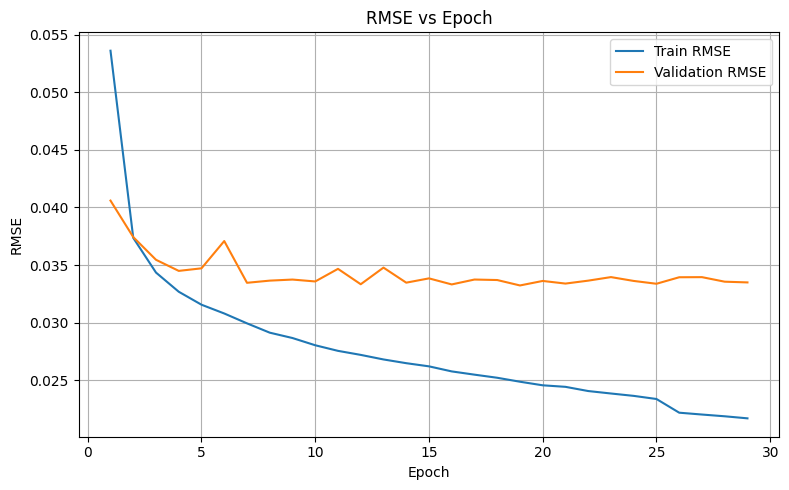

In [47]:
# Plot RMSE vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, label="Train RMSE")
plt.plot(range(1, len(val_rmse_list)+1), val_rmse_list, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE vs Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing and Evaluation

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize model
model = ModifiedMGATAFModel().to(device)

# Load best saved weights
model.load_state_dict(torch.load(f"models/modified_mgataf_type{ablation_study_id}_best_model.pt"))
model.eval()

ModifiedMGATAFModel(
  (drug_encoder): DrugGraphEncoder(
    (gats): ModuleList(
      (0): GATConv(55, 128, heads=4)
      (1-2): 2 x GATConv(128, 128, heads=4)
    )
    (att_proj): Linear(in_features=128, out_features=1, bias=True)
  )
  (gsva_encoder): GSVAEncoder(
    (conv): Sequential(
      (0): Conv1d(1, 32, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
      (3): ReLU()
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=5120, out_features=128, bias=True)
      (2): ReLU()
    )
  )
  (fusion): AdaptiveFusion(
    (gate_layer): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Sigmoid()
    )
  )
  (regressor): IC50Predictor(
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_fea

In [49]:
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for graph_data, fingerprint, ccl_feat, gsva_feat, label in test_loader:
        graph_data = graph_data.to(device)
        fingerprint = fingerprint.to(device)
        ccl_feat = ccl_feat.to(device)
        gsva_feat = gsva_feat.to(device)
        label = label.to(device)

        preds = model(graph_data, fingerprint, ccl_feat, gsva_feat)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# Flatten predictions and labels
y_pred = np.concatenate(all_preds).flatten()
y_true = np.concatenate(all_labels).flatten()

# Compute metrics
test_rmse = root_mean_squared_error(y_true, y_pred)
test_pcc = pearsonr(y_true, y_pred)[0]

print(f"✅ Test RMSE: {test_rmse:.4f}")
print(f"✅ Test PCC:  {test_pcc:.4f}")


✅ Test RMSE: 0.0353
✅ Test PCC:  0.8614


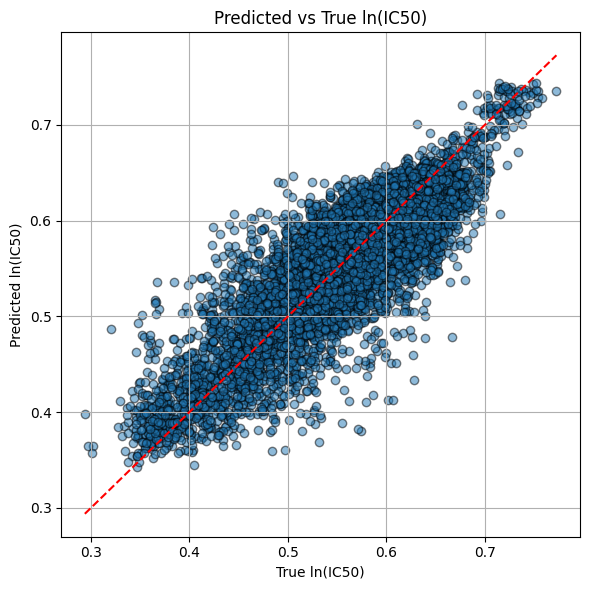

In [50]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True ln(IC50)")
plt.ylabel("Predicted ln(IC50)")
plt.title("Predicted vs True ln(IC50)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
def print_parameter_breakdown(model):
    total = 0
    print("\nTrainable Parameters by Module:\n")
    for name, param in model.named_parameters():
        if param.requires_grad:
            count = param.numel()
            print(f"{name:<50} {count:>10}")
            total += count
    print(f"\nTotal Trainable Parameters: {total:,}")

print_parameter_breakdown(model)



Trainable Parameters by Module:

drug_encoder.gats.0.att_src                               512
drug_encoder.gats.0.att_dst                               512
drug_encoder.gats.0.bias                                  128
drug_encoder.gats.0.lin.weight                          28160
drug_encoder.gats.1.att_src                               512
drug_encoder.gats.1.att_dst                               512
drug_encoder.gats.1.bias                                  128
drug_encoder.gats.1.lin.weight                          65536
drug_encoder.gats.2.att_src                               512
drug_encoder.gats.2.att_dst                               512
drug_encoder.gats.2.bias                                  128
drug_encoder.gats.2.lin.weight                          65536
drug_encoder.att_proj.weight                              128
drug_encoder.att_proj.bias                                  1
gsva_encoder.conv.0.weight                                256
gsva_encoder.conv.0.bias            